# Project Preparation

# **CODE**

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
import tensorflow as tf
import datetime
import math
import os
from enum import Enum
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.models import Model, load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout, Dense
from keras.layers import Rescaling
from tqdm import tqdm

2023-05-01 14:51:53.884602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 14:51:56.654929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
import qkeras
from qkeras import QActivation
from qkeras import QDense, QConv2D
from qkeras.autoqkeras import AutoQKeras

In [7]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

In [8]:
PRETRAINED = True
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


2023-05-01 14:52:03.376248: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-01 14:52:03.376282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: cmsgpu01.hep.wisc.edu
2023-05-01 14:52:03.376289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: cmsgpu01.hep.wisc.edu
2023-05-01 14:52:03.376373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-05-01 14:52:03.376405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-05-01 14:52:03.376412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [9]:
def load_masks(directory_path, patch_size):
    """
    :param patch_size: image patchify square size
    :param directory_path: path to root directory containing training and test images
    :return: list of images from directory
    """

    # initialize empty list for images
    instances = []

    # iterate through files in directory
    for filepath in tqdm(sorted(os.listdir(directory_path))):
        extension = filepath.split(".")[-1]
        if extension == "jpg" or extension == "png":

            # current image path
            img_path = rf"{directory_path}/{filepath}"
            #print(img_path)

            # convert image to RBG
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            thresh = 127
            max_val = 255
            

            size_x = (image.shape[1] // patch_size) * patch_size  # width to the nearest size divisible by patch size
            size_y = (image.shape[0] // patch_size) * patch_size  # height to the nearest size divisible by patch size

            image = Image.fromarray(image)

            # Crop original image to size divisible by patch size from top left corner
            image = np.array(image.crop((0, 0, size_x, size_y)))
            image = cv2.resize(image, (854, 854))
            image = cv2.resize(image, (160, 160))

            image = cv2.threshold(image, thresh, max_val, cv2.THRESH_BINARY)[1]
            image = image/255
            #plt.imshow(image)
            #plt.show()
            instances.append(np.squeeze(image))

    return instances

def load_images(directory_path, patch_size):
    """
    :param patch_size: image patchify square size
    :param directory_path: path to root directory containing training and test images
    :return: list of images from directory
    """

    # initialize empty list for images
    instances = []

    # iterate through files in directory
    for filepath in tqdm(sorted(os.listdir(directory_path))):
        extension = filepath.split(".")[-1]
        if extension == "jpg" or extension == "png":

            # current image path
            img_path = rf"{directory_path}/{filepath}"
            #print(img_path)

            # Reads image as BGR
            image = cv2.imread(img_path)

            # convert image to RBG
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            size_x = (image.shape[1] // patch_size) * patch_size  # width to the nearest size divisible by patch size
            size_y = (image.shape[0] // patch_size) * patch_size  # height to the nearest size divisible by patch size

            image = Image.fromarray(image)

            # Crop original image to size divisible by patch size from top left corner
            image = np.array(image.crop((0, 0, size_x, size_y)))
            image = cv2.resize(image, (854, 854))
            image = cv2.resize(image, (160, 160))
            instances.append(np.squeeze(image))

    return instances

# =====================================================
# prepare training data input images

def get_training_data(root_directory):
    # initialise lists
    image_dataset, mask_dataset = [], []
    ip, mp = [], []

    # define image patch size
    patch_size = 160
    
    # walk through root directory
    for path, directories, files in os.walk(root_directory):
        for subdirectory in directories:
            #print("subdirect",subdirectory)
            # extract training input images and patchify
            if subdirectory == "images":
                image_dataset.extend(
                    load_images(os.path.join(path, subdirectory), patch_size=patch_size))

            # extract training label masks and patchify
            elif subdirectory == "masks":
                mask_dataset.extend(
                    load_masks(os.path.join(path, subdirectory), patch_size=patch_size))
    # return input images and masks
    return np.array(image_dataset), np.array(mask_dataset), 


def create_binary_segmentation_problem(image_dataset, mask_dataset):
    # change problem to binary segmentation problem
    x_reduced, y_reduced = [], []

    # iterate over masks
    for j, mask in tqdm(enumerate(mask_dataset)):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create binary image (zeros)
        binary_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        # iterate over each pixel in mask
        for row in range(_img_height):
            for col in range(_img_width):
                # get image channel across axis=3
                rgb = mask[row, col, :]

                # building hex: #3C1098 = RGB(60, 16, 152) or BGR(152, 16, 60)
                binary_image[row, col] = 1 if rgb[0] == 60 and rgb[1] == 16 and rgb[2] == 152 else 0

        # only keep images with a high percentage of building coverage
        if np.count_nonzero(binary_image == 1) > 0.15 * binary_image.size:
            x_reduced.append(image_dataset[j])
            y_reduced.append(binary_image)

    # return binary image dataset
    return np.array(x_reduced), np.array(y_reduced)


# mask color codes
class MaskColorMap(Enum):
    car = (255, 255, 255)
    no_car = (0, 0, 0)

def one_hot_encode_masks(masks, num_classes):
    """
    :param masks: Y_train patched mask dataset
    :param num_classes: number of classes
    :return:
    """
    # initialise list for integer encoded masks
    """mapper = {x:[0]*num_classes for x in range(num_classes)}
    for k in mapper:
      temp = mapper[k]
      temp[k] = 1
      mapper[k] = temp"""

    integer_encoded_labels = []

    # iterate over each mask
    for mask in tqdm(masks):

        # get image shape
        _img_height, _img_width, _img_channel = mask.shape

        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j

        # append encoded image
        integer_encoded_labels.append(encoded_image)

    # return one-hot encoded labels
    return to_categorical(y=integer_encoded_labels, num_classes=num_classes)


# datetime for filename saving
dt_now = str(datetime.datetime.now()).replace(".", "_").replace(":", "_")
model_img_save_path = f"{os.getcwd()}/models/final_aerial_segmentation_{dt_now}.png"
model_save_path = f"{os.getcwd()}/models/cv_unet_lite_davis_{dt_now}.hdf5"
model_checkpoint_filepath = os.getcwd() + "/models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
csv_logger = rf"{os.getcwd()}/logs/aerial_segmentation_log_{dt_now}.csv"


# =======================================================
# training metrics

# Mean Intersection-Over-Union: iou = true_positives / (true_positives + false_positives + false_negatives)
def iou_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


# jaccard similarity: the size of the intersection divided by the size of the union of two sets
def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [10]:
BASE_PATH = ""
data_dir = BASE_PATH+'./'
#load_images_and_patchify_mask(BASE_PATH+data_dir+'masks', 160)
X, Y = get_training_data(root_directory=data_dir)
np.unique(Y)

100%|██████████| 195/195 [00:00<00:00, 197.26it/s]


array([0., 1.])

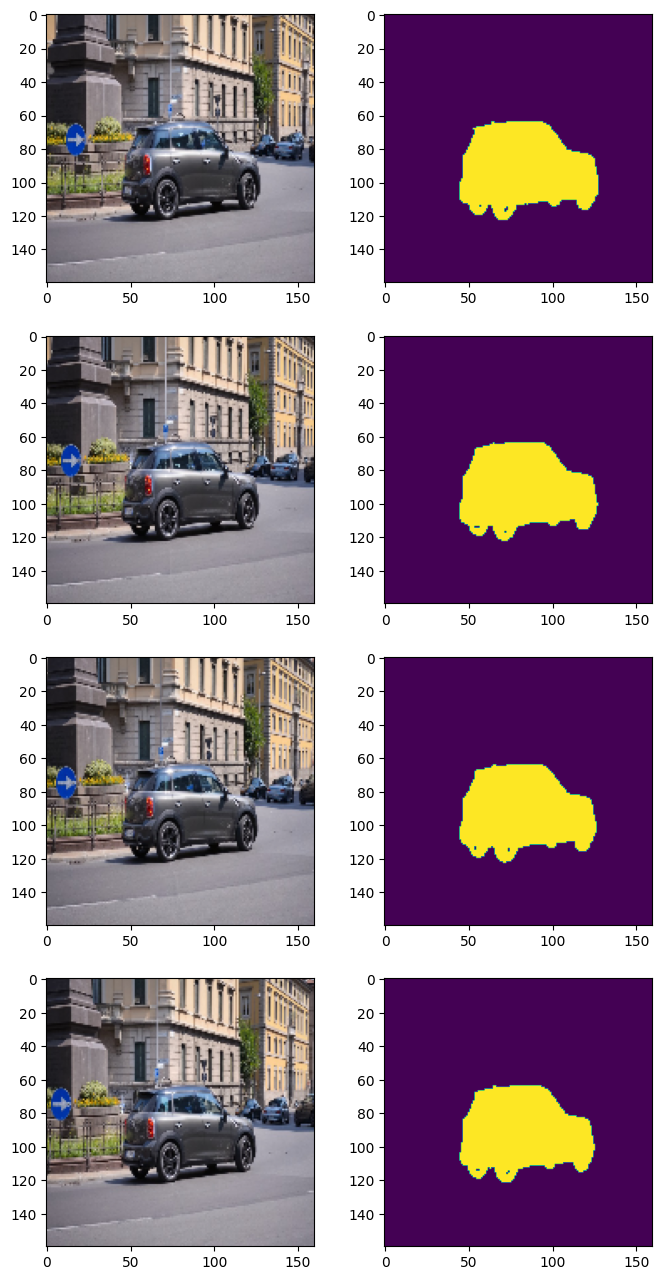

In [11]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(8,4*num_example_to_display))

for i in range(num_example_to_display):
    axs[i][0].imshow(X[50+i])
    axs[i][1].imshow(Y[50+i])

In [12]:
train_size = 10
X = X[:train_size]
Y = Y[:train_size]
X.shape, Y.shape

((10, 160, 160, 3), (10, 160, 160))

In [13]:
# =====================================================
# get training data
# number of classes in segmentation dataset
n_classes = 2
train_size = -1

# create (X, Y) training data
X, Y = get_training_data(root_directory=data_dir)

X = X[:train_size]
Y = Y[:train_size]
Y = np.expand_dims(Y, axis=-1)
    
# extract X_train shape parameters
m, img_height, img_width, img_channels = X.shape

# display images from both training and test sets
display_count = 6
random_index = [np.random.randint(0, m) for _ in range(display_count)]

sample_images = [x for z in zip(list(X[random_index]), list(Y[random_index])) for x in z]
#display_images(sample_images, rows=2)

# convert RGB values to integer encoded labels for categorical_crossentropy
Y = one_hot_encode_masks(Y, num_classes=n_classes)
X = X/255 # rescaling

# split dataset into training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
#X_train, X_test, Y_train, Y_test = X, X, Y, Y

100%|██████████| 194/194 [00:00<00:00, 559.96it/s]


In [14]:
X.shape, Y.shape

((194, 160, 160, 3), (194, 160, 160, 2))

In [15]:
# =====================================================
# define U-Net model architecture

def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
    #rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
    previous_block_activation = inputs # Set aside residual

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [16, 32, 64, 128]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([16, 32, 64, 128]):
        #x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = UpSampling2D((2,2))(previous_block_activation)
        x = Conv2D(f, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

In [141]:
# =====================================================
# define U-Net model architecture

def build_unet_v2(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
    #rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
    previous_block_activation = inputs # Set aside residual

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [16, 32, 64]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    #c5 = Dropout(0.2)(c5)
    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([16, 32, 64]):
        #x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = UpSampling2D((2,2))(previous_block_activation)
        x = Conv2D(f, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

In [16]:
def build_unet_v3(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
    #rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
    previous_block_activation = inputs # Set aside residual

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [4, 8, 16]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    #c5 = Dropout(0.2)(c5)
    c5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([4, 8, 16]):
        #x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = UpSampling2D((2,2))(previous_block_activation)
        x = Conv2D(f, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

In [17]:
IMG_SHAPE = 32
from keras.layers import MaxPooling2D, Input, concatenate, Conv2D, Activation, UpSampling2D, add, BatchNormalization

class EnetModel:
    '''
    Build ENET based model for segmentation task.
    Built for FPGA 240x152 implementation
    '''
  
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        # 8x Resolution Model
        fi, f1, f2, f3, f4, f5 = 16, 8, 4, 2, 4, 8

        # 240 x 152
        inputs = Input(input_size)

        initial = self.__InitialBlock(13, (3, 3), (2,2), inputs)
        encode1 = self.__EncoderBlock(fi, f1, initial)
        encode2 = self.__EncoderBlock(f1, f2, encode1)

        # 30 x 19 
        encode3 = Conv2D(filters=f3, kernel_size=(1, 1))(encode2)
        encode3 = BatchNormalization()(encode3)

        decode2 = self.__DecoderBlock(f3, f4, encode3)
        decode1 = self.__DecoderBlock(f4, f5, decode2)

        # 240 x 152
        outputs = self.__FinalBlock(OUTPUT_CHANNEL, decode1)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __InitialBlock(self, filters, kernel_size, pool_size, connecting_layer):
        pool_stride = (2, 2)
        pool = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        conv_i = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(pool)
        conv_i = BatchNormalization()(conv_i)

        # 3 layers + 29 layers from filters
        concat = concatenate([pool, conv_i], axis=-1)
        out = Activation("relu")(concat)

        return out
  
    def __FinalBlock(self, channels, connecting_layer):
        up_f = UpSampling2D(size=(2, 2))(connecting_layer)
        out = Conv2D(filters = channels, kernel_size=(2, 2), activation="softmax", padding="same")(up_f)
        return out

    def __EncoderBlock(self, filters_i, filters_o, connecting_layer):
        pool_size, pool_stride = (2, 2), (2, 2)
        pool_1 = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        conv_1 = Conv2D(filters=filters_i, kernel_size=(2,2), padding="same")(pool_1)
        conv_1 = BatchNormalization()(conv_1)

        x_1 = Activation("relu")(conv_1)

        conv_2 = Conv2D(filters=filters_i, kernel_size=(3,3), padding="same")(x_1)
        conv_2 = BatchNormalization()(conv_2)

        x_2 = Activation("relu")(conv_2)

        conv_3 = Conv2D(filters=filters_o, kernel_size=(1,1), padding="same")(x_2)
        conv_3 = BatchNormalization()(conv_3)

        # skip branch
        conv_4 = Conv2D(filters=filters_o, kernel_size=(1,1), padding="same")(pool_1)
        conv_4 = BatchNormalization()(conv_4)

        # add
        merged_layer = add([conv_3, conv_4])
        out = Activation("relu")(merged_layer)

        return out

    def __DecoderBlock(self, filters_i, filters_o, connecting_layer):

        # skip branch
        conv_1 = Conv2D(filters=filters_o, kernel_size=(1,1), padding="same")(connecting_layer)
        conv_1 = BatchNormalization()(conv_1)
        up_1 = UpSampling2D(size=(2, 2))(conv_1)

        # main_branch
        conv_2 = Conv2D(filters=filters_i, kernel_size=(2,2), padding="same")(connecting_layer)
        conv_2 = BatchNormalization()(conv_2)

        x_2 = Activation("relu")(conv_2)

        up_2 = UpSampling2D(size=(2, 2))(x_2)

        conv_3 = Conv2D(filters=filters_i, kernel_size=(3,3), padding="same")(up_2)
        conv_3 = BatchNormalization()(conv_3)

        x_3 = Activation("relu")(conv_3)

        conv_4 = Conv2D(filters=filters_o, kernel_size=(1, 1), padding="same")(x_3)
        conv_4 = BatchNormalization()(conv_4)

        # Add and ReLU
        merged_layer = add([up_1, conv_4])
        out = Activation("relu")(merged_layer)

        return out

def build_enet_v1(input_size):
    OUTPUT_CHANNEL = 2
    model = EnetModel().prepare_model(OUTPUT_CHANNEL, input_size)
    return model

In [18]:
#model = UNETLiteModel().prepare_model(2, (480, 480,3))
model = build_unet_v3((160, 160, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 4)  112         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 160, 160, 4)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 4)  148         ['dropout[0][0]']            

In [143]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name,layersize)) # 0 = weights, 1 = biases
        if (layersize > 4096): # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name,layersize))

conv2d_264: 432
conv2d_265: 2304
conv2d_266: 4608
Layer conv2d_266 is too large (4608), are you sure you want to train?
conv2d_267: 9216
Layer conv2d_267 is too large (9216), are you sure you want to train?
conv2d_268: 18432
Layer conv2d_268 is too large (18432), are you sure you want to train?
conv2d_269: 36864
Layer conv2d_269 is too large (36864), are you sure you want to train?
conv2d_270: 73728
Layer conv2d_270 is too large (73728), are you sure you want to train?
conv2d_271: 147456
Layer conv2d_271 is too large (147456), are you sure you want to train?
conv2d_272: 8192
Layer conv2d_272 is too large (8192), are you sure you want to train?
conv2d_273: 73728
Layer conv2d_273 is too large (73728), are you sure you want to train?
conv2d_274: 36864
Layer conv2d_274 is too large (36864), are you sure you want to train?
conv2d_275: 2048
conv2d_276: 18432
Layer conv2d_276 is too large (18432), are you sure you want to train?
conv2d_277: 9216
Layer conv2d_277 is too large (9216), are you s

In [144]:
model_img_save_path = f"{os.getcwd()}/models/cv_enet_lite_davis_450k_{dt_now}.png"
model_save_path = f"{os.getcwd()}/models/cv_enet_lite_davis_450k_{dt_now}.hdf5"
model_checkpoint_filepath = os.getcwd() + "/models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
csv_logger = rf"{os.getcwd()}/logs/aerial_segmentation_log_{dt_now}.csv"

In [145]:
# =======================================================
# add callbacks, compile model and fit training data

# save best model with maximum validation accuracy
checkpoint = ModelCheckpoint(model_checkpoint_filepath, monitor="val_accuracy", verbose=1, save_best_only=True,
                             mode="max")

# stop model training early if validation loss doesn't continue to decrease over 2 iterations
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="min")

# log training console output to csv
csv_logger = CSVLogger(csv_logger, separator=",", append=False)

# create list of callbacks
callbacks_list = [early_stopping, csv_logger]  # early_stopping

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", iou_coefficient, jaccard_index])

# train and save model
batch_size = 32
model.fit(X_train, Y_train, epochs=50, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=1, callbacks = callbacks_list)
    
model.save(model_save_path)
print("model saved:", model_save_path)

Epoch 1/50
6/6 [==============================] - 10s 1s/step - loss: 0.8663 - accuracy: 0.3590 - iou_coefficient: 0.2970 - jaccard_index: 0.2968 - val_loss: 0.5927 - val_accuracy: 0.8962 - val_iou_coefficient: 0.3844 - val_jaccard_index: 0.3843
Epoch 2/50
6/6 [==============================] - 8s 1s/step - loss: 0.4642 - accuracy: 0.8851 - iou_coefficient: 0.5881 - jaccard_index: 0.5858 - val_loss: 0.4074 - val_accuracy: 0.9021 - val_iou_coefficient: 0.5376 - val_jaccard_index: 0.5364
Epoch 3/50
6/6 [==============================] - 8s 1s/step - loss: 0.3885 - accuracy: 0.8902 - iou_coefficient: 0.5922 - jaccard_index: 0.5901 - val_loss: 0.3653 - val_accuracy: 0.9022 - val_iou_coefficient: 0.5920 - val_jaccard_index: 0.5902
Epoch 4/50
6/6 [==============================] - 8s 1s/step - loss: 0.3687 - accuracy: 0.8903 - iou_coefficient: 0.6689 - jaccard_index: 0.6657 - val_loss: 0.3462 - val_accuracy: 0.9022 - val_iou_coefficient: 0.6158 - val_jaccard_index: 0.6137
Epoch 5/50
6/6 [===

In [100]:
!pwd

/nfs_scratch/hsharma/u-net-aerial-imagery-segmentation


### Distiller Model and Process

In [19]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [45]:
def distiller_model(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)
    previous_block_activation = inputs

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [4, 8, 12]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    for f in reversed([4, 8, 12]):
        x = UpSampling2D((2,2))(previous_block_activation)
        x = Conv2D(f, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

In [21]:
def qdistiller_model(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)
    previous_block_activation = inputs

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [5, 10, 15]:
        x = QConv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        x = QConv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = QConv2D(20, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    c5 = QConv2D(20, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    for f in reversed([5, 10, 15]):
        x = UpSampling2D((2,2))(previous_block_activation)
        x = QConv2D(f, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = concatenate([x, contraction[f'conv{f}']])
        x = QConv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = QConv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = QConv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

In [46]:
dmodel = distiller_model((160, 160, 3))
dmodel.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 160, 160, 4)  112         ['input_5[0][0]']                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 160, 160, 4)  148         ['conv2d_31[0][0]']              
                                                                                                  
 max_pooling2d_11 (MaxPooling2D  (None, 80, 80, 4)   0           ['conv2d_32[0][0]']        

In [47]:
for layer in dmodel.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name,layersize)) # 0 = weights, 1 = biases
        if (layersize > 4096): # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name,layersize))

conv2d_31: 108
conv2d_32: 144
conv2d_33: 288
conv2d_34: 576
conv2d_35: 864
conv2d_36: 1296
conv2d_37: 1728
conv2d_38: 2304
conv2d_39: 192
conv2d_40: 2592
conv2d_41: 1296
conv2d_42: 96
conv2d_43: 1152
conv2d_44: 576
conv2d_45: 32
conv2d_46: 288
conv2d_47: 144
conv2d_48: 8


In [26]:
batch_size = 32

In [50]:
dmodel_save_path = f"{os.getcwd()}/models/cv_unet_lite_davis_450k-12k_distill_{dt_now}.hdf5"

In [49]:
distiller = Distiller(student=dmodel, teacher=model)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy", iou_coefficient, jaccard_index],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(X_train, Y_train, epochs=50, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/50
6/6 [==============================] - 4s 268ms/step - accuracy: 0.7127 - iou_coefficient: 0.3481 - jaccard_index: 0.3481 - student_loss: 0.6596 - distillation_loss: 3.8459e-04 - val_accuracy: 0.8667 - val_iou_coefficient: 0.3700 - val_jaccard_index: 0.3700 - val_student_loss: 0.6190
Epoch 2/50
6/6 [==============================] - 1s 222ms/step - accuracy: 0.8772 - iou_coefficient: 0.3777 - jaccard_index: 0.3776 - student_loss: 0.6018 - distillation_loss: 3.7325e-04 - val_accuracy: 0.9007 - val_iou_coefficient: 0.3952 - val_jaccard_index: 0.3951 - val_student_loss: 0.5737
Epoch 3/50
6/6 [==============================] - 1s 222ms/step - accuracy: 0.8896 - iou_coefficient: 0.4044 - jaccard_index: 0.4042 - student_loss: 0.5560 - distillation_loss: 3.6638e-04 - val_accuracy: 0.9018 - val_iou_coefficient: 0.4286 - val_jaccard_index: 0.4283 - val_student_loss: 0.5219
Epoch 4/50
6/6 [==============================] - 1s 217ms/step - accuracy: 0.8900 - iou_coefficient: 0.4404 - j

Epoch 29/50
6/6 [==============================] - 1s 233ms/step - accuracy: 0.9643 - iou_coefficient: 0.8654 - jaccard_index: 0.8632 - student_loss: 0.1064 - distillation_loss: 1.4259e-04 - val_accuracy: 0.9665 - val_iou_coefficient: 0.8826 - val_jaccard_index: 0.8804 - val_student_loss: 0.0929
Epoch 30/50
6/6 [==============================] - 1s 229ms/step - accuracy: 0.9673 - iou_coefficient: 0.8766 - jaccard_index: 0.8747 - student_loss: 0.0945 - distillation_loss: 1.2336e-04 - val_accuracy: 0.9673 - val_iou_coefficient: 0.8896 - val_jaccard_index: 0.8877 - val_student_loss: 0.0923
Epoch 31/50
6/6 [==============================] - 1s 236ms/step - accuracy: 0.9676 - iou_coefficient: 0.8818 - jaccard_index: 0.8800 - student_loss: 0.0895 - distillation_loss: 1.2259e-04 - val_accuracy: 0.9668 - val_iou_coefficient: 0.8959 - val_jaccard_index: 0.8943 - val_student_loss: 0.0957
Epoch 32/50
6/6 [==============================] - 1s 229ms/step - accuracy: 0.9703 - iou_coefficient: 0.8899

model saved: /nfs_scratch/hsharma/u-net-aerial-imagery-segmentation/models/cv_unet_lite_davis_450k-7k_distill_2023-05-01 14_52_03_553482.hdf5


In [75]:
distiller.student.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", iou_coefficient, jaccard_index])
distiller.student.save(dmodel_save_path)
print("model saved:", dmodel_save_path)

model saved: /nfs_scratch/hsharma/u-net-aerial-imagery-segmentation/models/cv_unet_lite_davis_450k-12k_distill_2023-05-01 14_52_03_553482.hdf5


In [29]:
from qkeras import print_qstats
# for automatic quantization
import pprint
from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize

from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from qkeras import quantized_bits
from qkeras import QDense, QActivation

In [244]:
# QModel Energy Profile: Teacher
q = run_qtools.QTools(tmodel, 
                      process="horowitz", 
                      source_quantizers=[quantized_bits(16, 5, 1)], 
                      is_inference=True, 
                      weights_path=None,
                      keras_quantizer="fp16",
                      keras_accumulator="fp16", 
                      for_reference=False)
q.qtools_stats_print()

energy_dict = q.pe(
    weights_on_memory="fixed",
    activations_on_memory="fixed",
    min_sram_size=8*16*1024*1024,
    rd_wr_on_io=False)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(
    qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(
    qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()

print("Total energy: {:.6f} uJ".format(total_energy / 1000000.0))

{
    "source_quantizers": [
        {
            "quantizer_type": "quantized_bits",
            "bits": 16,
            "int_bits": 6,
            "is_signed": true
        }
    ],
    "conv2d_264": {
        "layer_type": "Conv2D",
        "input_quantizer_list": [
            {
                "quantizer_type": "quantized_bits",
                "bits": 16,
                "int_bits": 6,
                "is_signed": true
            }
        ],
        "weight_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": [
                3,
                3,
                3,
                16
            ]
        },
        "bias_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": 16
        },
        "multiplier": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "op_type": "mul"
        },
        "accumulator": {
            "quantizer_

In [30]:
# Energy Profiling dmodel: Student w/o Quantization
q = run_qtools.QTools(dmodel, 
                      process="horowitz", 
                      source_quantizers=[quantized_bits(16, 5, 1)], 
                      is_inference=True, 
                      weights_path=None,
                      keras_quantizer="fp16",
                      keras_accumulator="fp16", 
                      for_reference=False)
q.qtools_stats_print()

energy_dict = q.pe(
    weights_on_memory="fixed",
    activations_on_memory="fixed",
    min_sram_size=8*16*1024*1024,
    rd_wr_on_io=False)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(
    qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(
    qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()

print("Total energy: {:.6f} uJ".format(total_energy / 1000000.0))

Instructions for updating:
Use ref() instead.
{
    "source_quantizers": [
        {
            "quantizer_type": "quantized_bits",
            "bits": 16,
            "int_bits": 6,
            "is_signed": true
        }
    ],
    "conv2d_317": {
        "layer_type": "Conv2D",
        "input_quantizer_list": [
            {
                "quantizer_type": "quantized_bits",
                "bits": 16,
                "int_bits": 6,
                "is_signed": true
            }
        ],
        "weight_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": [
                3,
                3,
                3,
                4
            ]
        },
        "bias_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": 4
        },
        "multiplier": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "op_type": "mul"
        },
    

In [74]:
# Energy Profiling dmodel: Student with Quantization
q = run_qtools.QTools(model, 
                      process="horowitz", 
                      source_quantizers=[quantized_bits(16, 5, 1)], 
                      is_inference=True, 
                      weights_path=None,
                      keras_quantizer="fp16",
                      keras_accumulator="fp16", 
                      for_reference=False)
q.qtools_stats_print()

energy_dict = q.pe(
    weights_on_memory="fixed",
    activations_on_memory="fixed",
    min_sram_size=8*16*1024*1024,
    rd_wr_on_io=False)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(
    qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(
    qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()

print("Total energy: {:.6f} uJ".format(total_energy / 1000000.0))

{
    "source_quantizers": [
        {
            "quantizer_type": "quantized_bits",
            "bits": 16,
            "int_bits": 6,
            "is_signed": true
        }
    ],
    "conv2d_31": {
        "layer_type": "Conv2D",
        "input_quantizer_list": [
            {
                "quantizer_type": "quantized_bits",
                "bits": 16,
                "int_bits": 6,
                "is_signed": true
            }
        ],
        "weight_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": [
                3,
                3,
                3,
                4
            ]
        },
        "bias_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": 4
        },
        "multiplier": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "op_type": "mul"
        },
        "accumulator": {
            "quantizer_typ

### Evaluation

In [67]:
model_dir = os.getcwd()+'/models/'
model_name = 'cv_unet_lite_davis_450k-12k_distill_2023-05-01 14_52_03_553482.hdf5'

model = load_model(
    model_dir + model_name,
    custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index}
)

In [68]:
model = dmodel

In [69]:
X_test.shape

(20, 160, 160, 3)

1/1 [==============================] - 0s 143ms/step


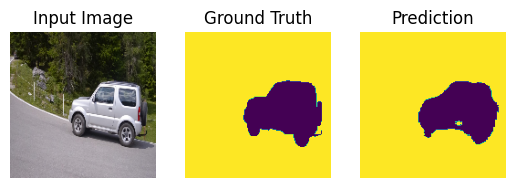

1/1 [==============================] - 0s 31ms/step


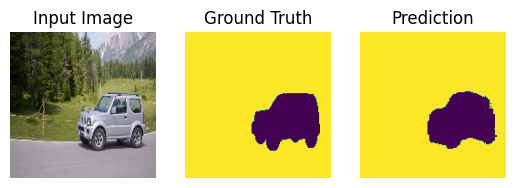

1/1 [==============================] - 0s 32ms/step


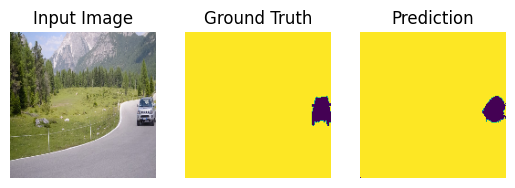

1/1 [==============================] - 0s 32ms/step


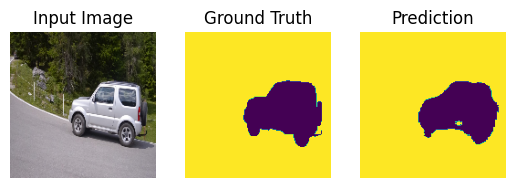

1/1 [==============================] - 0s 33ms/step


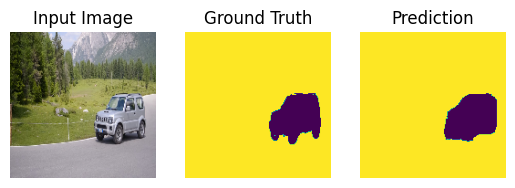

1/1 [==============================] - 0s 32ms/step


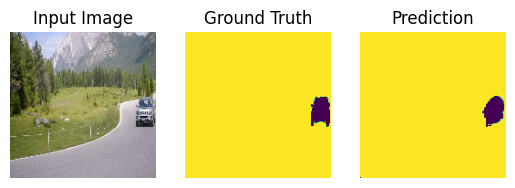

1/1 [==============================] - 0s 33ms/step


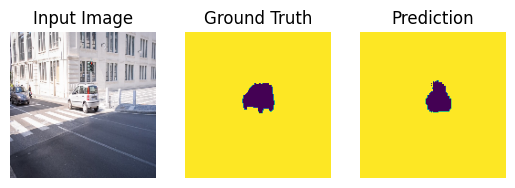

1/1 [==============================] - 0s 33ms/step


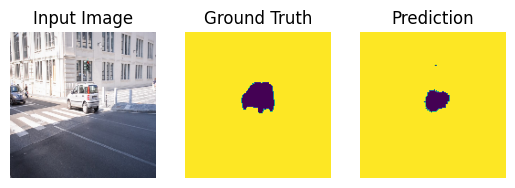

1/1 [==============================] - 0s 44ms/step


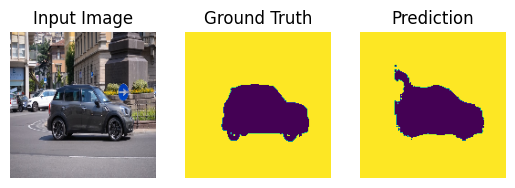

1/1 [==============================] - 0s 32ms/step


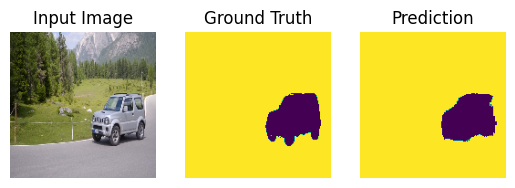

In [70]:
'''def rgb_encode_mask(mask):
    # initialize rgb image with equal spatial resolution
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))

    # iterate over MaskColorMap
    for j, cls in enumerate(MaskColorMap):
        # convert single integer channel to RGB channels
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
    return rgb_encode_image'''

def rgb_encode_mask(mask):
    # initialize rgb image with equal spatial resolution
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # convert binary mask to RGB format
    rgb_encode_image[mask == 1] = (255, 255, 255)  # white for foreground
    rgb_encode_image[mask == 0] = (0, 0, 0)  # black for background

    return rgb_encode_image


for _ in range(10):
    # choose random number from 0 to test set size
    test_img_number = np.random.randint(0, len(X_test))

    # extract test input image
    test_img = X_test[test_img_number]

    # ground truth test label converted from one-hot to integer encoding
    ground_truth = np.argmax(Y_test[test_img_number], axis=-1)

    # expand first dimension as U-Net requires (m, h, w, nc) input shape
    test_img_input = np.expand_dims(test_img, 0)

    # make prediction with model and remove extra dimension
    prediction = np.squeeze(model.predict(test_img_input))
    
    # convert softmax probabilities to integer values
    predicted_img = np.argmax(prediction, axis=-1)

    #plt.imshow(predicted_img)
    # convert integer encoding to rgb values
    rgb_image = rgb_encode_mask(predicted_img)
    rgb_ground_truth = rgb_encode_mask(ground_truth)

    # visualize model predictions
    test_img = test_img
    display_images(
        [test_img, ground_truth, predicted_img],
        rows=1, titles=['Input Image', 'Ground Truth', 'Prediction']
    )

In [72]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", iou_coefficient, jaccard_index])

In [73]:
# Test Scores
test_score_baseline = model.evaluate(X_test, Y_test)

print('Scores: ', test_score_baseline)

1/1 [==============================] - 0s 402ms/step - loss: 0.0401 - accuracy: 0.9837 - iou_coefficient: 0.9557 - jaccard_index: 0.9556
Scores:  [0.04008166119456291, 0.9837363362312317, 0.9557150602340698, 0.9555988907814026]
